<a href="https://colab.research.google.com/github/doudi0101/Google_AI/blob/main/RNN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## La construction de RNN est amusante avec PyTorch et Google Colab
Dans ce tutoriel, nous allons apprendre à construire un réseau neuronal récurrent (RNN) à une seule couche, constituée d'un seul neurone, avec PyTorch et Google Colab. Nous allons aussi implémenter un modèle simple basé sur un RNN pour la classification d'images.

Nous allons utiliser Google Colab et nous devons donc d'abord installer manuellement la bibliothèque PyTorch. Vous pouvez le faire en utilisant la commande suivante :

In [1]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Nous pouvons maintenant importer les bibliothèques nécessaires que nous utiliserons dans le tutoriel :

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

### RNN avec un seul neurone


L'idée de ce tutoriel est de vous montrer les opérations de base nécessaires pour construire une architecture RNN à l'aide de PyTorch. Ce guide suppose que vous avez des connaissances de base sur les RNN . J'essaierai de passer en revue les RNN dans la mesure du possible pour ceux qui ont besoin d'un rafraîchissement, mais je m'en tiendrai au minimum.

Tout d'abord, construisons le graphe de calcul d'un RNN à une couche. Encore une fois, nous ne sommes pas concernés par les mathématiques pour le moment, je veux juste vous montrer les opérations PyTorch nécessaires pour construire vos modèles RNN.

À titre d'illustration, voici l'architecture que nous construisons :

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQXBLYvvI1dqAHdLA0hQdsP1PojmCfuSCMK2DXEL0uTvRUqvD1eYK8fsECcNCoekxCbgWJ-k7QF_1s4/pub?w=600&h=400)

Et voici le code :

In [3]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1
        
        self.b = torch.zeros(1, n_neurons) # 1 X 4
        
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1
        
        return self.Y0, self.Y1

Dans le code ci-dessus, nous implémentons un simple RNN à une couche et un neurone. Nous initialisons deux matrices de poids, `Wx` et `Wy` avec des valeurs provenant d'une distribution normale. `Wx` contient les poids de connexion pour les entrées du pas de temps courant, tandis que `Wy` contient les poids de connexion pour les sorties du pas de temps précédent. Nous avons ajouté un biais `b`. La fonction `forward` calcule deux sorties -- une pour chaque pas de temps... deux dans ce cas. Notez que nous utilisons `tanh` comme non-linéarité (fonction d'activation).

En ce qui concerne l'entrée, nous fournissons 4 instances, chaque instance contenant deux séquences d'entrée.

À titre d'illustration, voici comment les données sont introduites dans le modèle RNN : 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vRpQYtOzO1U_3yQLf1885kMaja6MsXtJ8QnlqxrfpTgZmb4WpewJXphGdmotYXDB1VE6zlW6cBY_WqR/pub?w=600&h=600)

Et voici le code pour tester le modèle :

In [4]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

Après avoir introduit les entrées dans le graphe de calcul, nous obtenons des sorties pour chaque pas de temps (`Y0`, `Y1`), que nous pouvons maintenant imprimer comme suit :

In [5]:
print(Y0_val)
print(Y1_val)

tensor([[ 0.4639],
        [-0.2917],
        [-0.8016],
        [-1.0000]])
tensor([[-0.9946],
        [ 0.0286],
        [-0.9660],
        [-0.8358]])


### Augmentation du nombre de neurones dans la couche RNN
Ensuite, je vais vous montrer comment généraliser le RNN que nous venons de construire pour que la couche unique supporte un nombre `n` de neurones. En termes d'architecture, rien ne change vraiment puisque nous avons déjà paramétré le nombre de neurones dans le graphe de calcul que nous avons construit. Cependant, la taille de la sortie change puisque nous avons modifié la taille du nombre d'unités (c'est-à-dire de neurones) dans la couche RNN. 

Voici une illustration de ce que nous allons construire :

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQov6BGg1fXOb7Bg5zenPh7R5j6VsZJh_D6JevQ_sm_fCxmXORxad3qLIFGG1FojzJig0qdcAQoGYoN/pub?w=600&h=404)

Et voici le code :

In [6]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons) # n_neurons X n_neurons
        
        self.b = torch.zeros(1, n_neurons) # 1 X n_neurons
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # batch_size X n_neurons
        
        return self.Y0, self.Y1

In [7]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

Maintenant, lorsque nous imprimons les sorties produites pour chaque pas de temps, elles sont de taille (`4 X 5`), ce qui représente la taille du lot et le nombre de neurones, respectivement.

In [8]:
print(Y0_val)
print(Y1_val)

tensor([[-0.7967, -0.9439, -0.9983, -0.5506,  0.8655],
        [-1.0000, -0.9295, -1.0000, -1.0000,  1.0000],
        [-1.0000, -0.9117, -1.0000, -1.0000,  1.0000],
        [-0.9998,  1.0000, -0.8266, -1.0000,  1.0000]])
tensor([[-1.0000, -0.8431, -1.0000, -1.0000,  1.0000],
        [ 0.6410, -0.9974, -0.5209, -0.9992,  0.9941],
        [-1.0000, -0.8567, -1.0000, -1.0000,  1.0000],
        [-0.9788,  0.9351, -1.0000, -1.0000,  1.0000]])


### PyTorch Built-in RNN Cell

Si vous regardez de plus près le graphe de calcul `BasicRNN` que nous venons de construire, il présente un sérieux défaut. Et si nous voulions construire une architecture qui supporte des entrées et des sorties extrêmement grandes. De la manière dont elle est actuellement construite, elle nous obligerait à calculer individuellement les sorties pour chaque pas de temps, ce qui augmenterait le nombre de lignes de code nécessaires pour implémenter le graphe de calcul souhaité. Ci-dessous, nous allons consolider et mettre en œuvre cette méthode de manière plus efficace et plus propre en utilisant le module RNNCell intégré.

Essayons d'abord d'implémenter ceci de manière informelle pour analyser le rôle que joue `RNNCell` :

In [9]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.0360,  0.1083,  0.9492, -0.4407, -0.9559],
        [ 0.2305, -0.9621,  0.9630,  0.3831, -0.9913],
        [ 0.9310, -0.9376,  0.9995,  0.5633, -0.9999],
        [ 0.9995, -0.9854,  0.1655,  0.7828, -0.9710]],
       grad_fn=<TanhBackward0>), tensor([[ 0.9741, -0.9980,  0.9988,  0.8619, -0.9998],
        [ 0.6105, -0.1836,  0.3863,  0.0284,  0.0256],
        [ 0.9715, -0.9707,  0.9878,  0.8203, -0.9795],
        [ 0.9047, -0.8211,  0.8366,  0.4689, -0.6324]],
       grad_fn=<TanhBackward0>)]


Avec le code ci-dessus, nous avons essentiellement implémenté le même modèle que celui implémenté dans `BasicRNN`. `torch.RNNCell(...)` fait toute la magie de créer et de maintenir les poids et les biais nécessaires pour nous. `torch.RNNCell` accepte un tenseur en entrée et sort le prochain état caché pour chaque élément du lot. Pour en savoir plus sur ce module, cliquez ici (https://pytorch.org/docs/stable/nn.html?highlight=rnncell#torch.nn.RNNCell).

Maintenant, construisons formellement le graphe de calcul en utilisant les mêmes informations que nous avons utilisées ci-dessus.

In [10]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

In [11]:
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contain values for final state or final timestep, i.e., t=1

[tensor([[ 0.5100,  0.6530, -0.2106, -0.8053, -0.3440],
        [ 0.6455,  0.9764,  0.9816, -0.9921,  0.9091],
        [ 0.9166,  0.9971,  0.9997, -0.9958,  0.9937],
        [-0.9021,  0.4769,  0.9668,  0.6163,  0.7315]],
       grad_fn=<TanhBackward0>), tensor([[ 0.9774,  0.9991,  0.9997, -0.9491,  0.9569],
        [ 0.7975,  0.6687,  0.6437,  0.1457, -0.7305],
        [ 0.9564,  0.9953,  0.9986, -0.7959,  0.5857],
        [-0.0738,  0.9213,  0.9686, -0.1145, -0.3271]],
       grad_fn=<TanhBackward0>)]
tensor([[ 0.9774,  0.9991,  0.9997, -0.9491,  0.9569],
        [ 0.7975,  0.6687,  0.6437,  0.1457, -0.7305],
        [ 0.9564,  0.9953,  0.9986, -0.7959,  0.5857],
        [-0.0738,  0.9213,  0.9686, -0.1145, -0.3271]],
       grad_fn=<TanhBackward0>)


Vous pouvez voir que le code est beaucoup plus propre puisque nous n'avons pas besoin d'opérer explicitement sur les poids comme indiqué dans l'extrait de code précédent -- tout est géré implicitement et éloquemment par PyTorch.

### RNN for Image Classification

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vSiMstqkE9hTYmhPD3KMeFRNNKYA2NnrCayahBOEL1TalRqaWF7rH8a7O-nP9c-mKOdZRsWtmAGZfNN/pub?w=969&h=368)

Maintenant que vous avez appris à construire un simple RNN à partir de rien et en utilisant le module intégré `RNNCell` fourni dans PyTorch, faisons quelque chose de plus sophistiqué et spécial.

Essayons de construire un classificateur d'images en utilisant le jeu de données MNIST. Le jeu de données MNIST est constitué d'images contenant des chiffres écrits à la main de 1 à 10. Essentiellement, nous voulons construire un classificateur pour prédire les chiffres affichés par un ensemble d'images. Je sais que cela peut paraître étrange, mais vous serez surpris par les performances des RNN dans cette tâche de classification d'images.

De plus, nous utiliserons également le module `RNN` au lieu du module `RNNCell` puisque nous voulons généraliser le graphe de calcul pour pouvoir supporter un nombre `n` de couches également. Nous n'utiliserons qu'une seule couche dans le graphe de calcul suivant, mais vous pourrez expérimenter le code plus tard en ajoutant d'autres couches.

#### Importation du dataset
Avant de construire le graphe de calcul basé sur les RNN, nous allons importer l'ensemble de données MNIST, le diviser en parties test et train, effectuer quelques transformations et l'explorer davantage. Vous aurez besoin des bibliothèques PyTorch et des lignes de code suivantes pour télécharger et importer le jeu de données MNIST dans Google Colab.

In [12]:
import torchvision
import torchvision.transforms as transforms

In [13]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Le code ci-dessus charge et prépare l'ensemble de données à introduire dans le graphe de calcul que nous construirons plus tard. Prenez quelques minutes pour jouer avec le code et comprendre ce qui se passe. Remarquez que nous avons dû fournir une taille de lot. C'est parce que `trainloader` et `testloader` sont des itérateurs, ce qui rendra plus facile l'itération sur le jeu de données et l'entraînement de notre modèle RNN avec des minibatchs.

#### Explorer le dataset
Voici quelques lignes de code pour explorer l'ensemble de données. Je ne couvrirai pas une grande partie de ce qui se passe ici, mais vous pouvez prendre un peu de temps et l'examiner par vous-même.

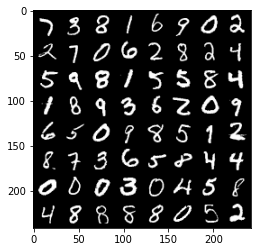

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Modèle
Construisons le graphe de calcul. Voici les paramètres :

In [15]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

Et enfin, voici une figure du modèle de classification basé sur les RNN que nous construisons :

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

Et voici le code pour le modèle :

In [16]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

Le modèle `ImageRNN` fait ce qui suit :
- La fonction d'initialisation `__init__(...)` déclare quelques variables, puis une couche RNN de base `basic_rnn` suivie d'une couche entièrement connectée `self.FC`.
- La fonction `init_hidden` initialise les poids cachés avec des valeurs nulles. 
La fonction `forward` accepte une entrée de taille `n_steps X batch_size X n_neurons`. Les données traversent ensuite la couche RNN, puis la couche entièrement connectée. 
- La sortie est constituée des probabilités logarithmiques du modèle.

#### Tester le modèle avec quelques échantillons
Une très bonne pratique encouragée par les développeurs de PyTorch dans toute leur documentation, et que j'aime beaucoup et recommande vivement, est de toujours tester le modèle avec une partie de l'ensemble de données avant l'entraînement réel. Cela permet de s'assurer que vous avez spécifié la bonne dimension et que le modèle produit les informations que vous attendez. Je vous montre ci-dessous un exemple de la façon de tester votre modèle :


In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0967, -0.0513, -0.0138,  0.0255,  0.0227,  0.0833,  0.0451, -0.1000,
         -0.0747, -0.0312],
        [-0.0996, -0.0552, -0.0166,  0.0272,  0.0269,  0.0897,  0.0510, -0.0912,
         -0.0714, -0.0293],
        [-0.0980, -0.0544, -0.0223,  0.0229,  0.0270,  0.0824,  0.0536, -0.0943,
         -0.0709, -0.0349],
        [-0.1051, -0.0517,  0.0023,  0.0255,  0.0258,  0.0987,  0.0484, -0.1220,
         -0.0737, -0.0322],
        [-0.0962, -0.0500, -0.0097,  0.0268,  0.0311,  0.0905,  0.0405, -0.1039,
         -0.0679, -0.0329],
        [-0.0914, -0.0543, -0.0202,  0.0225,  0.0316,  0.0871,  0.0448, -0.0861,
         -0.0683, -0.0347],
        [-0.0700, -0.0526,  0.0159,  0.0414,  0.0225,  0.0887, -0.0168, -0.0926,
         -0.0335, -0.0380],
        [-0.1019, -0.0617, -0.0100,  0.0270,  0.0215,  0.0932,  0.0495, -0.1093,
         -0.0656, -0.0306],
        [-0.0666, -0.0809, -0.0212,  0.0499,  0.0145,  0.0793,  0.0084, -0.0649,
         -0.0728, -0.0354],
        [-0.0937, -

#### Training

Voyons maintenant le code pour l'entraînement du modèle de classification d'images. Mais d'abord, déclarons quelques fonctions d'aide nécessaires à l'entraînement du modèle :

In [18]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Avant d'entraîner un modèle dans PyTorch, vous pouvez spécifier par programme quel périphérique vous voulez utiliser pendant l'entraînement ; la fonction `torch.device(...)` indique au programme que nous voulons utiliser le GPU s'il est disponible, sinon le CPU sera le périphérique par défaut.

Ensuite, nous créons une instance du modèle, `ImageRNN(...)`, avec les paramètres appropriés. Le critère représente la fonction que nous allons utiliser pour calculer la perte du modèle. La fonction `nn.CrossEntropyLoss()` applique essentiellement un log softmax suivi d'une opération de perte de vraisemblance log négative sur la sortie du modèle. Pour calculer la perte, la fonction a besoin des probabilités logarithmiques et des cibles. Nous verrons plus loin dans notre code comment les fournir au critère.

Pour l'entraînement, nous avons également besoin d'un algorithme d'optimisation qui aide à mettre à jour les poids en fonction de la perte actuelle. Ceci est réalisé avec la fonction d'optimisation `optim.Adam`, qui requiert les paramètres du modèle et un taux d'apprentissage. Alternativement, vous pouvez aussi utiliser la fonction d'optimisation `optim.SGD` ou tout autre algorithme d'optimisation disponible. 

La fonction `get_accuracy(...)` calcule simplement la précision du modèle en fonction des probabilités logarithmiques et des valeurs cibles. A titre d'exercice, vous pouvez écrire du code pour tester cette fonction comme nous l'avons fait avec le modèle auparavant.

Rassemblons tout et entraînons notre modèle de classification d'images :

In [19]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6952 | Train Accuracy: 77.41
Epoch:  1 | Loss: 0.2889 | Train Accuracy: 91.61
Epoch:  2 | Loss: 0.2120 | Train Accuracy: 94.00
Epoch:  3 | Loss: 0.1792 | Train Accuracy: 94.98
Epoch:  4 | Loss: 0.1610 | Train Accuracy: 95.48
Epoch:  5 | Loss: 0.1527 | Train Accuracy: 95.75
Epoch:  6 | Loss: 0.1363 | Train Accuracy: 96.19
Epoch:  7 | Loss: 0.1341 | Train Accuracy: 96.21
Epoch:  8 | Loss: 0.1211 | Train Accuracy: 96.64
Epoch:  9 | Loss: 0.1192 | Train Accuracy: 96.71


Nous pouvons également calculer la précision (accuracy) sur l'ensemble de données de test pour tester la performance du modèle sur la tâche de classification d'images. Comme vous pouvez le voir ci-dessous, notre modèle RNN est très performant sur la tâche de classification MNIST.


In [21]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.79


### References
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://github.com/omarsar/pytorch_intro_neural_network/blob/master/nn.ipynb)
- [Hands on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)